In [1]:
fp = '/local/cms/user/eichl008/ldmx/eat/v14/8gev/bkgd/enriched-nuclear-1/category_nuclear_Nevents_1M_MaxTries_1_BiasFactor_200_BiasThresh_3000_MinNucE_5000_nruns_50_startrun_5050.root'

In [2]:
import uproot
import awkward as ak
import numpy as np
import hist
import mplhep
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from helpy import upldmx

In [4]:
events = upldmx.arrays(
    fp = fp,
    branches = {
        'EcalRecHits_eat': upldmx.as_rec_hit,
        'HcalRecHits_eat': upldmx.as_hcal_rec_hit
    }
)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f588860d2b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

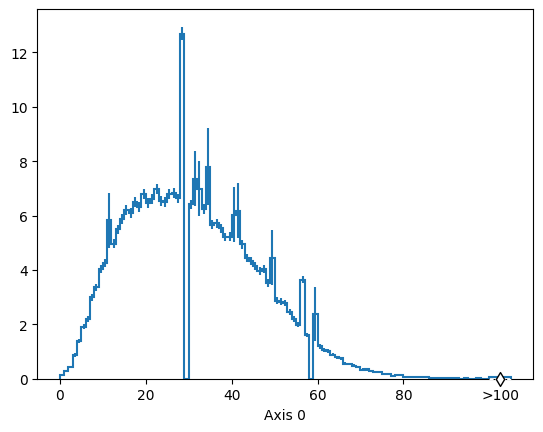

In [14]:
hist.Hist.new.Reg(100,0,100).Weight().fill(
    ak.count(events.HcalRecHits.id[events.HcalRecHits.pe >= 10], axis=1),
    weight = events.weight
).plot1d(flow='show')

In [36]:
from collections import namedtuple
ShowerFeatures = namedtuple('ShowerFeatures',('total_energy','center_x','center_y','transverse_rms'))

def shower_features(ecal_rec_hits):
    total_energy = ak.sum(ecal_rec_hits.energy, axis=1)
    center_x = ak.sum(ecal_rec_hits.energy*ecal_rec_hits.xpos, axis=1)/total_energy
    center_y = ak.sum(ecal_rec_hits.energy*ecal_rec_hits.ypos, axis=1)/total_energy
    transverse_rms = ak.sum(
        ecal_rec_hits.energy*np.sqrt(
            (ecal_rec_hits.xpos - center_x)**2 + (ecal_rec_hits.ypos - center_y)**2
        ), axis=1)/total_energy
    return ShowerFeatures(total_energy, center_x, center_y, transverse_rms)

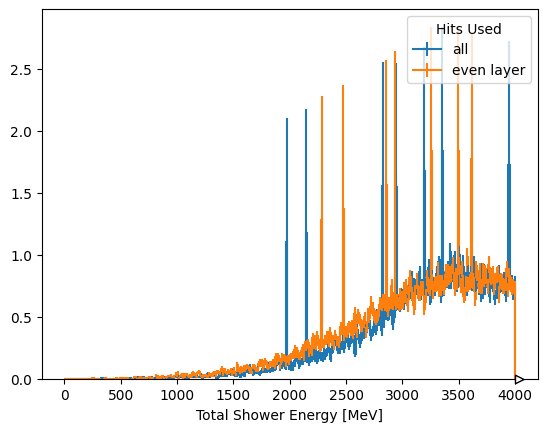

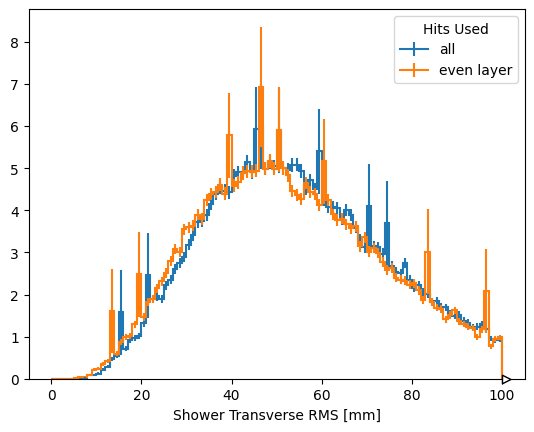

In [39]:
allhits = shower_features(events.EcalRecHits)
evenhits = shower_features(events.EcalRecHits[events.EcalRecHits.layer%2==0])

tre_h = (
    hist.Hist.new
        .StrCategory(['all','even layer'],name='Hits Used')
        .Reg(400,0,4000, name='Total Shower Energy [MeV]')
        .Weight()
)
tre_h.fill('all',allhits.total_energy, weight = events.weight)
tre_h.fill('even layer', 2*evenhits.total_energy, weight = events.weight)
tre_h.plot()
plt.show()

rms_h = (
    hist.Hist.new
        .StrCategory(['all','even layer'],name='Hits Used')
        .Reg(100,0,100, name='Shower Transverse RMS [mm]')
        .Weight()
)
rms_h.fill('all', allhits.transverse_rms, weight = events.weight)
rms_h.fill('even layer', evenhits.transverse_rms, weight = events.weight)
rms_h.plot()
plt.show()

In [70]:
hit_cost = events.HcalRecHits.layer*2*np.floor(np.abs(events.HcalRecHits.strip - 19.5))

In [71]:
would_veto = (events.HcalRecHits.pe >= 10)&(events.HcalRecHits.section == 0)
optimal_veto_hit = ak.firsts(events.HcalRecHits[would_veto][ak.argsort(hit_cost[would_veto])], axis=1)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f581cb51c10>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f581cbc1c10>, text=[])

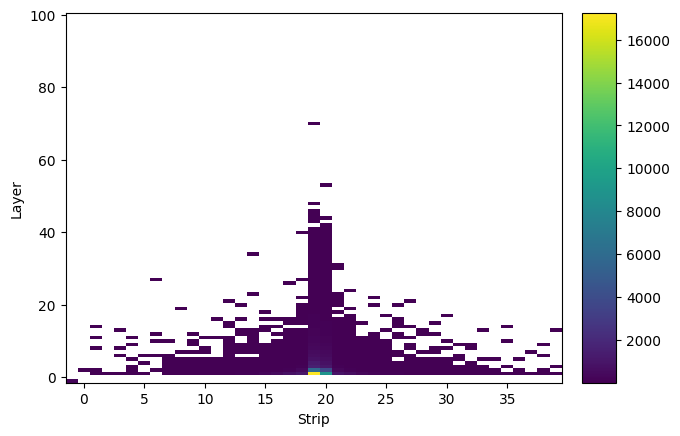

In [74]:
h = (hist.Hist.new
     .Reg(41,-1.5,39.5, name='Strip')
     .Reg(102,-1.5,100.5, name='Layer')
     .Double()
    )
h.fill(
    ak.fill_none(optimal_veto_hit.strip, -1),
    ak.fill_none(optimal_veto_hit.layer, -1)
)
h.plot2d(cmin=1)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f581ca593d0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f581cc22de0>, text=[])

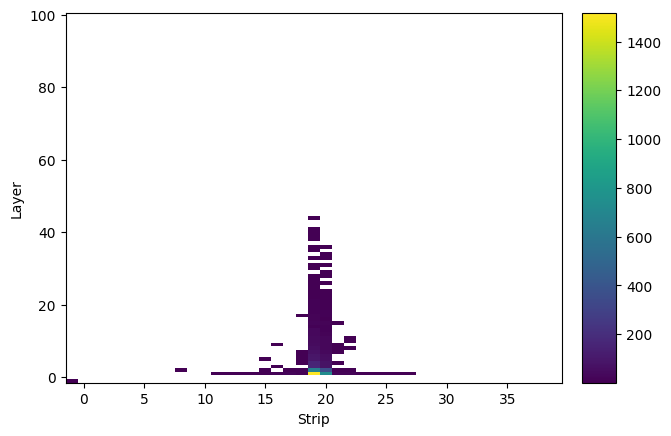

In [75]:
necessary_optimal_veto_hit = optimal_veto_hit[allhits.total_energy < 2760]
h = (hist.Hist.new
     .Reg(41,-1.5,39.5, name='Strip')
     .Reg(102,-1.5,100.5, name='Layer')
     .Double()
    )
h.fill(
    ak.fill_none(necessary_optimal_veto_hit.strip, -1),
    ak.fill_none(necessary_optimal_veto_hit.layer, -1)
)
h.plot2d(cmin=1)